In [3]:
import sys, os, subprocess, shutil, glob, pathlib

print("Python:", sys.version)
print("Interpreter:", sys.executable)

env_name = os.path.basename(sys.prefix) or "current-env"
print("Detected environment name:", env_name)

req_file = "requirements.txt"
if os.path.exists(req_file):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", req_file])
else:
    subprocess.check_call([sys.executable, "-m", "pip", "install",
                           "numpy==1.23.5", "scipy==1.15.3",
                           "parmap==1.7.0", "pandas==2.3.1",
                           "scikit-learn==1.7.1"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "setuptools>=68", "wheel", "Cython<3.1"])
subprocess.check_call([sys.executable, "-m", "ipykernel", "install",
                       "--user", "--name", env_name, "--display-name", f"Python ({env_name})"])

for p in ["build", "__pycache__"]:
    shutil.rmtree(p, ignore_errors=True)
for f in glob.glob("ns_hmm.*.so") + glob.glob("ns_hmm.*.pyd") + glob.glob("ns_hmm.c"):
    pathlib.Path(f).unlink(missing_ok=True)

for key in ("CFLAGS", "CPPFLAGS", "CXXFLAGS"):
    if key in os.environ:
        os.environ.pop(key)

if os.path.exists("setup.py"):
    print("\n[Build] python setup.py build_ext --inplace ...")
    subprocess.check_call([sys.executable, "setup.py", "build_ext", "--inplace"])
else:
    raise FileNotFoundError("setup.py not found in current directory.")

import importlib
try:
    import ns_hmm
except Exception:
    if "ns_hmm" in sys.modules:
        del sys.modules["ns_hmm"]
    importlib.invalidate_caches()
    import ns_hmm

print("\nSetup complete. ns_hmm loaded:", ns_hmm)
print(f"Jupyter kernel registered as: Python ({env_name})")


Python: 3.10.18 (main, Jun  5 2025, 08:37:47) [Clang 14.0.6 ]
Interpreter: /opt/anaconda3/envs/MSH_Bayes/bin/python3.10
Detected environment name: MSH_Bayes
Installed kernelspec MSH_Bayes in /Users/seongyu/Library/Jupyter/kernels/msh_bayes

[Build] python setup.py build_ext --inplace ...
Compiling ns_hmm.pyx because it changed.
[1/1] Cythonizing ns_hmm.pyx
running build_ext
building 'ns_hmm' extension
creating build/temp.macosx-11.1-arm64-cpython-310
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/MSH_Bayes/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/MSH_Bayes/include -arch arm64 -I/opt/anaconda3/envs/MSH_Bayes/lib/python3.10/site-packages/numpy/core/include -I/opt/anaconda3/envs/MSH_Bayes/include/python3.10 -c ns_hmm.c -o build/temp.macosx-11.1-arm64-cpython-310/ns_hmm.o -Wno-unreachable-code-fallthrough -O3 -Wno-cpp
creating build/lib.macosx-11.1-arm64-cpython-310
clang -bundle -undefined dyna

ld: warning: duplicate -rpath '/opt/anaconda3/envs/MSH_Bayes/lib' ignored



Setup complete. ns_hmm loaded: <module 'ns_hmm' from '/Users/seongyu/Desktop/research/Multi-state-BM-main/ns_hmm.cpython-310-darwin.so'>
Jupyter kernel registered as: Python (MSH_Bayes)


In [4]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import math
import seaborn as sns
from matplotlib import gridspec
import multiprocessing
from multiprocessing import get_context
import parmap
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
from sklearn.mixture import BayesianGaussianMixture as BGMM
import sys, subprocess, shutil, glob, pathlib, os, site, platform, threading
print("Python:", sys.version)
print("Interpreter:", sys.executable)
print("Site-packages:", site.getsitepackages())
print("OS:", platform.platform())

Python: 3.10.18 (main, Jun  5 2025, 08:37:47) [Clang 14.0.6 ]
Interpreter: /opt/anaconda3/envs/MSH_Bayes/bin/python3.10
Site-packages: ['/opt/anaconda3/envs/MSH_Bayes/lib/python3.10/site-packages']
OS: macOS-15.3.2-arm64-arm-64bit


In [5]:
plt.rcParams["font.family"] = "times new roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 75
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20 

from matplotlib_inline.backend_inline import set_matplotlib_formats

# Nested sampling run

In [10]:
# user-configurable parameters
user_params = {
    "D_min": 0.001,
    "D_max": 2.0,
    "unit_T": 0.1,
    "unit_L": 0.167,
}
path = 'test_dataset_short'

ns_hmm.set_params(user_params)
fnames = np.genfromtxt(f'{path}/filenames.txt', dtype=str)
print(ns_hmm.get_params())  # check

{'D_min': 0.001, 'D_max': 2.0, 'unit_T': 0.1, 'unit_L': 0.167}


In [ ]:
fnum = len(fnames)
findices = np.arange(1, fnum + 1)
num_cores = min(os.cpu_count(), fnum)
indices = np.array_split(findices, num_cores)

print(fnames)
for i in range(fnum):
    globals()[f'trj_{i+1}'] = np.genfromtxt(f'{path}/{fnames[i]}')

def start_logger(ctx):
    mgr = ctx.Manager()
    q = mgr.Queue()
    def _listener():
        for msg in iter(q.get, None):
            print(msg, flush=True)
    t = threading.Thread(target=_listener, daemon=True)
    t.start()
    return q, t, mgr

start_method = "fork" if sys.platform != "win32" else "spawn"
ctx = get_context(start_method)

USE_LOG_QUEUE = True
log_q, t, mgr = (None, None, None)
if USE_LOG_QUEUE:
    log_q, t, mgr = start_logger(ctx)

def _init_worker(params):
    import ns_hmm as _m
    _m.set_params(params)

with ctx.Pool(processes=num_cores, initializer=_init_worker, initargs=(user_params,)) as pool:
    results = parmap.map(
        ns_hmm.mp_nested_sampling,
        indices,
        200, 100000, 0.0001, 0.25, 30, path,
        log_q=log_q,
        pm_pbar=True, pm_pool=pool
    )

if USE_LOG_QUEUE:
    log_q.put(None)
    t.join()


['trj1.txt' 'trj2.txt' 'trj3.txt']
log(Z_remain / Z): 695.6660062409887
log(Z_remain / Z): 682.6987906267592
log(Z_remain / Z): 252.42074085948374
log(Z_remain / Z): 40.75723446344261
log(Z_remain / Z): 54.05066820489439
log(Z_remain / Z): 122.48377606457379
log(Z_remain / Z): 22.565980717617613
log(Z_remain / Z): 32.977039267972174
log(Z_remain / Z): 90.23625153364793
log(Z_remain / Z): 11.664353715340841
log(Z_remain / Z): 17.454017229004812
log(Z_remain / Z): 56.74399504210919
log(Z_remain / Z): 5.748341100455989
log(Z_remain / Z): 7.645421151991348
log(Z_remain / Z): 2.8615573759052646
log(Z_remain / Z): 37.20648488867109
log(Z_remain / Z): 4.018946944965702
log(Z_remain / Z): 1.2185043083153326
log(Z_remain / Z): 19.90807742877066
log(Z_remain / Z): 1.8901702105382618
log(Z_remain / Z): 0.1746182642437335
log(Z_remain / Z): 9.195474061433302
log(Z_remain / Z): 0.595189586230144
log(Z_remain / Z): -0.6111907202347324
log(Z_remain / Z): -1.2696953808847589
log(Z_remain / Z): -0.3021

# AIC calculation

In [5]:
AIC = np.zeros((fnum, 3))
for j in range(fnum):
    temp_AIC = np.inf
    for k in range(3):
        nstates = k + 1
        with open('{}/results/{}totalseries{}state.pkl'.format(path, j+1, nstates), 'rb') as f:
            temp = pickle.load(f)
        temp_MLE = temp[np.argmax(temp[:, nstates**2]), :]
        AIC[j, k] = 2 * (nstates ** 2) - 2 * temp_MLE[nstates ** 2]
        
        if AIC[j, k] < temp_AIC: # model selection
            temp_AIC = AIC[j, k]
            globals()['MLE{}'.format(j+1)] = temp_MLE.copy() # MLE with minimum AIC

with open('{}/results/AIC.pkl'.format(path), 'wb') as f:
    pickle.dump(AIC, f)
        
AIC = np.concatenate((set1_AIC, set2_AIC), axis = 0)

# Model selection

In [8]:
model_AIC = np.zeros(fnum, dtype = int)
with open('{}/results/AIC.pkl'.format(path), 'rb') as f:
    IC = pickle.load(f)
model_AIC = np.argmin(IC, axis = 1) + 1
            
model_Bayes = np.zeros(fnum, dtype = int)
for i in range(fnum):
    with open('{}/results/prob{}.pkl'.format(path, i + 1), 'rb') as f:
        prob = pickle.load(f)
    model_Bayes[i] = np.argmax(prob) + 1

In [25]:
model_AIC

array([2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       2, 1, 2, 1, 2, 1], dtype=int64)

# Parameter estimation (MLE, MAP)

In [ ]:
ns_hmm.NS_Params('uniform', 'AIC', path, fnum)
ns_hmm.NS_Params('uniform', 'Bayesian', path, fnum)

In [6]:
AIC_MLE_ds = []
AIC_MAP_ds = []
cnt = 0

####--AIC, MLE

for j in range(fnum):
    with open('{}/results/MLE{}_{}.pkl'.format(path, j+1, 'AIC'), 'rb') as f:
        temp = pickle.load(f)
    temp = temp.flatten()
    for k in range(np.sqrt(len(temp)-1).astype(int)):
        AIC_MLE_ds.append(temp[k])
        
####--AIC, MLE

####--AIC, MAP

for j in range(fnum):
    with open('{}/results/MAP{}_{}.pkl'.format(path, j+1, 'AIC'), 'rb') as f:
        temp = pickle.load(f)
    temp = temp.flatten()
    for k in range(np.sqrt(len(temp)-1).astype(int)):
        AIC_MAP_ds.append(temp[k])

####--AIC, MAP

In [7]:
Bayes_MLE_ds = []
Bayes_MAP_ds = []
cnt = 0

####--Bayes, MLE

for j in range(fnum):
    with open('{}/results/MLE{}_{}.pkl'.format(path, j+1, 'Bayesian'), 'rb') as f:
        temp = pickle.load(f)
    temp = temp.flatten()
    for k in range(np.sqrt(len(temp)-1).astype(int)):
        Bayes_MLE_ds.append(temp[k])
        
####--Bayes, MLE


####--Bayes, MAP

for j in range(fnum):
    with open('{}/results/MAP{}_{}.pkl'.format(path, j+1, 'Bayesian'), 'rb') as f:
        temp = pickle.load(f)
    temp = temp.flatten()
    for k in range(np.sqrt(len(temp)-1).astype(int)):
        Bayes_MAP_ds.append(temp[k])

####--Bayes, MAP

# Parameter clustering

### AIC

49
weight: 0.48439322854246064
mu: [0.35995965]
var: 0.07172205602884993
36
weight: 0.33580007109852694
mu: [0.06048195]
var: 0.044563358566743254
16
weight: 0.1650178099059343
mu: [0.00446527]
var: 0.2962464061899724
0
weight: 0.01478889045307804
mu: [0.09045379]
var: 0.060119975657845166
49
weight: 0.4842005173504086
mu: [0.35193424]
var: 0.06636718003045726
35
weight: 0.32333521269600024
mu: [0.06448872]
var: 0.038953986386944014
17
weight: 0.17764635549279736
mu: [0.00594333]
var: 0.30606775445160883
0
weight: 0.014817914460793837
mu: [0.09286594]
var: 0.060050563777616764


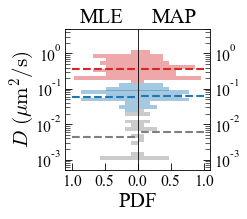

In [9]:
colors = ['tab:red', 'tab:blue', 'tab:grey', 'tab:grey']

gs = plt.GridSpec(1, 2, wspace = 0, width_ratios=[1, 1])
fig = plt.figure(figsize = (2.5, 2.5))

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey = ax1)

####--BGMM, MLE & MLE plot

AIC_MLE_ds = np.array(AIC_MLE_ds)
bgmm = BGMM(n_components = 4,
            max_iter = 50,
            n_init = 50,
            init_params = 'kmeans',
            random_state = 1,
            weight_concentration_prior = 20,
            mean_precision_prior = 0.5,
            covariance_type = 'spherical',
#            covariance_prior = 0.6,
            covariance_prior = 0.3,
            degrees_of_freedom_prior = 5).fit(np.log10(AIC_MLE_ds[:, None]))
bgmm_labels = bgmm.predict(np.log10(AIC_MLE_ds[:, None])) 
    
mu = bgmm.means_
var = bgmm.covariances_
weights = bgmm.weights_

hist, bins = np.histogram(np.log10(AIC_MLE_ds), density = True, bins = np.linspace(-3, 0.5, 35))
bins = (bins[:len(bins) - 1] + (bins[1] - bins[0]) / 2).copy()

for i in range(4):
    print(len(AIC_MLE_ds[bgmm_labels == i]))
    print('weight:', weights[i])
    print('mu:', 10**mu[i])
    print('var:', var[i])

for i in range(3):
    globals()['AICMLEbound{}'.format(i+1)] = np.min(AIC_MLE_ds[bgmm_labels == i])
    globals()['index{}'.format(i+1)] = np.where(globals()['AICMLEbound{}'.format(i+1)] <= 10 ** bins)[0][0]

ax1.barh(10**bins[index1:], hist[index1:], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index1:], color = colors[0], alpha = 0.4)
ax1.barh(10**bins[index2:index1], hist[index2:index1], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index2:index1], color = colors[1], alpha = 0.4)
ax1.barh(10**bins[index3:index2], hist[index3:index2], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index3:index2], color = colors[2], alpha = 0.4)
ax1.barh(10**bins[:index3], hist[:index3], height = (bins[1] - bins[0]) * 2.3 * 10**bins[:index3], color = colors[3], alpha = 0.4)

ax1.invert_xaxis()
ax1.set_yscale('log')
ax1.set_xlim(1.1, 0)
ax1.set_ylim(0.0005, 5)
ax1.set_xticks([1, 0.5])
ax1.set_title('MLE')

xspace2 = np.linspace(1, 0, 5)
for i in range(3):
    ax1.plot(xspace2, 10**mu[i] * np.ones(len(xspace2)), '--', linewidth = 2, color = colors[i])

####--BGMM, MLE & MLE plot


####-MAP plot

AIC_MAP_ds = np.array(AIC_MAP_ds)
bgmm = BGMM(n_components = 4,
            max_iter = 50,
            n_init = 50,
            init_params = 'kmeans',
            random_state = 1,
            weight_concentration_prior = 20,
            mean_precision_prior = 0.5,
            covariance_type = 'spherical',
#            covariance_prior = 0.6,
            covariance_prior = 0.3,
            degrees_of_freedom_prior = 5).fit(np.log10(AIC_MAP_ds[:, None]))
bgmm_labels = bgmm.predict(np.log10(AIC_MAP_ds[:, None])) 
    
mu = bgmm.means_
var = bgmm.covariances_
weights = bgmm.weights_
    
hist, bins = np.histogram(np.log10(AIC_MAP_ds), density = True, bins = np.linspace(-3, 0.5, 35))
bins = (bins[:len(bins) - 1] + (bins[1] - bins[0]) / 2).copy()

for i in range(4):
    print(len(AIC_MAP_ds[bgmm_labels == i]))
    print('weight:', weights[i])
    print('mu:', 10**mu[i])
    print('var:', var[i])

for i in range(3):
    globals()['AICMAPbound{}'.format(i+1)] = np.min(AIC_MAP_ds[bgmm_labels == i])
    globals()['index{}'.format(i+1)] = np.where(globals()['AICMAPbound{}'.format(i+1)] <= 10 ** bins)[0][0]

ax2.barh(10**bins[index1:], hist[index1:], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index1:], color = colors[0], alpha = 0.4)
ax2.barh(10**bins[index2:index1], hist[index2:index1], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index2:index1], color = colors[1], alpha = 0.4)
ax2.barh(10**bins[index3:index2], hist[index3:index2], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index3:index2], color = colors[2], alpha = 0.4)

#yspace = np.linspace(-3, 0.2, 1000)
#for i in range(len(mu)):
#    ax2.plot(weights[i].flatten() * norm.pdf(yspace, mu[i].flatten(), var[i].flatten()), 10 ** yspace)

ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.set_xlim(0, 1.1)
ax2.set_xticks([0, 0.5, 1])
ax2.set_title('MAP')
ax2.set_xlabel('PDF')
ax2.xaxis.set_label_coords(0, -0.15)
ax1.yaxis.set_label_coords(-0.4, 0.5)
ax1.set_ylabel(r'$D~(\mu \mathrm{m^2 / s})$')

for i in range(3):
    ax2.plot(xspace2, 10**mu[i] * np.ones(len(xspace2)), '--', linewidth = 2, color = colors[i])

plt.plot()
####-MAP plot

####--average transition matrix
P_avg = np.zeros((2, 2))
cnt = 0

for j in range(fnum[i]):
    with open('{}/results/MAP{}_{}.pkl'.format(path, j+1, 'AIC'), 'rb') as f:
        temp = pickle.load(f)
        tempD, tempP = sample_sorting(temp, np.sqrt(len(temp)-1).astype(int))
            
ax1.tick_params(which = 'major', labelsize = 15, direction = 'in', length = 7, bottom = True)
ax1.tick_params(which = 'minor', direction = 'in', length = 5)
ax2.tick_params(which = 'major', labelsize = 15, direction = 'in', length = 7, bottom = True)
ax2.tick_params(which = 'minor', direction = 'in', length = 5)
               
               
ax1.set_yticks([0.001, 0.01, 0.1, 1])
ax2.set_yticks([0.001, 0.01, 0.1, 1])
               
               
ax1.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))
ax2.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))
#ax2.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=5))

#plt.savefig('AIC_clustering.pdf', format = 'pdf', dpi = 1200)

### Bayesian

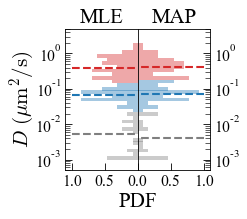

In [10]:
####--model histogram & plot setting

gs = plt.GridSpec(1, 2, wspace = 0, width_ratios=[1, 1])
fig = plt.figure(figsize = (2.5, 2.5))

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey = ax1)

####--model histogram & plot setting

####--BGMM, MLE & MLE plot

Bayes_MLE_ds = np.array(Bayes_MLE_ds)
bgmm = BGMM(n_components = 4,
            max_iter = 50,
            n_init = 20,
            init_params = 'kmeans',
            random_state = 1,
            weight_concentration_prior = 20,
            mean_precision_prior = 0.5,
            covariance_type = 'spherical',
            covariance_prior = 0.3,
            degrees_of_freedom_prior = 5).fit(np.log10(Bayes_MLE_ds[:, None]))
bgmm_labels = bgmm.predict(np.log10(Bayes_MLE_ds[:, None])) 
    
mu = bgmm.means_
var = bgmm.covariances_
weights = bgmm.weights_

hist, bins = np.histogram(np.log10(Bayes_MLE_ds), density = True, bins = np.linspace(-3, 0.5, 35))
bins = (bins[:len(bins) - 1] + (bins[1] - bins[0]) / 2).copy()

for i in range(4):
    print(len(Bayes_MLE_ds[bgmm_labels == i]))
    print('weight:', weights[i])
    print('mu:', 10**mu[i])
    print('var:', var[i])
    
for i in range(3):
    globals()['bound{}'.format(i+1)] = np.min(Bayes_MLE_ds[bgmm_labels == i])
    globals()['bayesMLEbound{}'.format(i+1)] = np.min(Bayes_MLE_ds[bgmm_labels == i])
    globals()['index{}'.format(i+1)] = np.where(globals()['bound{}'.format(i+1)] <= 10 ** bins)[0][0]

ax1.barh(10**bins[index1:], hist[index1:], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index1:], color = colors[0], alpha = 0.4)
ax1.barh(10**bins[index2:index1], hist[index2:index1], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index2:index1], color = colors[1], alpha = 0.4)
ax1.barh(10**bins[index3:index2], hist[index3:index2], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index3:index2], color = colors[2], alpha = 0.4)
#ax1.barh(10**bins[:index3], hist[:index3], height = (bins[1] - bins[0]) * 2.3 * 10**bins[:index3], color = colors[3], alpha = 0.4)

ax1.invert_xaxis()
ax1.set_yscale('log')
ax1.set_xlim(1.1, 0)
ax1.set_ylim(0.0005, 5)
ax1.set_xticks([1, 0.5])
ax1.set_title('MLE')
ax1.tick_params(which = 'both', direction = 'in')

xspace2 = np.linspace(1, 0, 5)
for i in range(3):
    ax1.plot(xspace2, 10**mu[i] * np.ones(len(xspace2)), '--', linewidth = 2, color = colors[i])

####--BGMM, MLE & MLE plot

####-MAP plot

Bayes_MAP_ds = np.array(Bayes_MAP_ds)
bgmm = BGMM(n_components = 4,
            max_iter = 50,
            n_init = 20,
            init_params = 'kmeans',
            random_state = 1,
            weight_concentration_prior = 20,
            mean_precision_prior = 0.5,
            covariance_type = 'spherical',
            covariance_prior = 0.3,
            degrees_of_freedom_prior = 5).fit(np.log10(Bayes_MAP_ds[:, None]))
bgmm_labels = bgmm.predict(np.log10(Bayes_MAP_ds[:, None])) 
    
mu = bgmm.means_
var = bgmm.covariances_
weights = bgmm.weights_
    
hist, bins = np.histogram(np.log10(Bayes_MAP_ds), density = True, bins = np.linspace(-3, 0.5, 35))
bins = (bins[:len(bins) - 1] + (bins[1] - bins[0]) / 2).copy()

for i in range(4):
    print(len(Bayes_MAP_ds[bgmm_labels == i]))
    print('weight:', weights[i])
    print('mu:', 10**mu[i])
    print('var:', var[i])
    
for i in range(3):
    globals()['bound{}'.format(i+1)] = np.min(Bayes_MAP_ds[bgmm_labels == i])
    globals()['bayesMAPbound{}'.format(i+1)] = np.min(Bayes_MAP_ds[bgmm_labels == i])
    globals()['index{}'.format(i+1)] = np.where(globals()['bound{}'.format(i+1)] <= 10 ** bins)[0][0]

ax2.barh(10**bins[index1:], hist[index1:], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index1:], color = colors[0], alpha = 0.4)
ax2.barh(10**bins[index2:index1], hist[index2:index1], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index2:index1], color = colors[1], alpha = 0.4)
ax2.barh(10**bins[index3:index2], hist[index3:index2], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index3:index2], color = colors[2], alpha = 0.4)

#yspace = np.linspace(-3, 0.2, 1000)
#for i in range(len(mu)):
#    ax2.plot(weights[i].flatten() * norm.pdf(yspace, mu[i].flatten(), var[i].flatten()), 10 ** yspace)

ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.set_xlim(0, 1.1)
ax2.set_xticks([0, 0.5, 1])
ax2.set_title('MAP')
ax2.set_xlabel('PDF')
ax2.xaxis.set_label_coords(0, -0.15)
ax2.tick_params(which = 'both', direction = 'in')

ax1.yaxis.set_label_coords(-0.4, 0.5)
ax1.set_ylabel(r'$D~(\mu \mathrm{m^2 / s})$')

for i in range(3):
    ax2.plot(xspace2, 10**mu[i] * np.ones(len(xspace2)), '--', linewidth = 2, color = colors[i])

    
ax1.tick_params(which = 'major', labelsize = 15, direction = 'in', length = 7, bottom = True)
ax1.tick_params(which = 'minor', direction = 'in', length = 5)
ax2.tick_params(which = 'major', labelsize = 15, direction = 'in', length = 7, bottom = True)
ax2.tick_params(which = 'minor', direction = 'in', length = 5)
               
               
ax1.set_yticks([0.001, 0.01, 0.1, 1])
ax2.set_yticks([0.001, 0.01, 0.1, 1])
               
               
ax1.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))
ax2.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))

plt.plot()

####--average transition matrix
P_avg = np.zeros((2, 2))
cnt = 0

for j in range(fnum):
    with open('{}/results/MAP{}_{}.pkl'.format(path, j+1, 'AIC'), 'rb') as f:
        temp = pickle.load(f)
        tempD, tempP = sample_sorting(temp, np.sqrt(len(temp)-1).astype(int))
        if len(tempD) == 2:
            if bound1 <= tempD[1] and bound2 <= tempD[0] < bound1:
                P_avg += tempP
                cnt += 1
P_avg /= cnt
#print(P_avg)

####--average transition matrix

#plt.savefig('Bayes_clustering_appendix.pdf', format = 'pdf', dpi = 1200)